In [1]:
import os 
import json
import pandas as pd
import numpy as np

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

from scapy.all import *

import pprint

C:\Users\larad\AppData\Local\Temp\ipykernel_5496\1396370143.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\larad\AppData\Local\Programs\Python\Python311\Lib\site-packages\scapy\layers\ipsec.py:471: CryptographyDeprecationWarning: Blowfish has been deprecated
  cipher=algorithms.Blowfish,
c:\Users\larad\AppData\Local\Programs\Python\Python311\Lib\site-packages\scapy\layers\ipsec.py:485: CryptographyDeprecationWarning: CAST5 has been deprecated
  cipher=algorithms.CAST5,
ERROR: Loading module scapy.layers.ssl_tls
Traceback (most recent call last):
  File "c:\Users\larad\AppData\Local\Pr

# QUIC Data Analysis

### Parsing *qlog* Records

In [2]:
def parseQlogFile(qlog_file_path, regex):
    f = open(qlog_file_path, 'r')
    qlog_data = f.read()
    f.close()

    records = qlog_data.strip().split(regex)
    parsedRecords = [json.loads(string.strip()) for string in records]

    # Extract all transport records and all parameter-setting records
    transport_records = [record for record in parsedRecords[1:] if 'packet_sent' in record["name"] or 'packet_received' in record["name"]]
    parameters_set_records = [record for record in parsedRecords[1:] if 'parameters_set' in record["name"]]
    
    # Parse records for information
    connection_establishment_handshake_time, tls_handshake_time, time_to_data_transfer = getHandshakeTimes(transport_records)
    error_reason = getError(transport_records)
    tls_established = getTLSInfo(parameters_set_records)
    round_trip_times = calculateRTTQUIC(transport_records)

    return connection_establishment_handshake_time, tls_handshake_time, time_to_data_transfer, error_reason, tls_established, round_trip_times


def getHandshakeTimes(records):
    initial_packet_time = records[0]["time"]
    all_handshake_end_time = 0
    tls_handshake_packets, connection_establishment_handshake_packets = getHandshakePackets(records)

    # Get time of first data packet:
    for record in records:
        packet_type = record["data"]["header"]["packet_type"]
        if packet_type != "initial" and packet_type != "handshake":
            all_handshake_end_time = record["time"]
            break
    
    if len(connection_establishment_handshake_packets) == 0:
        return (None, None, None)
    
    # Get time of first data packet after connection establishment handshake:
    connection_establishment_handshake_start_time = connection_establishment_handshake_packets[0]["time"]
    connection_establishment_handshake_end_time = connection_establishment_handshake_packets[-1]["time"]
    

    if len(tls_handshake_packets) == 0:
        return (connection_establishment_handshake_end_time - connection_establishment_handshake_start_time, None, None)
    
    # Get time of first data packet after TLS handshake:
    tls_handshake_start_time = tls_handshake_packets[0]["time"]
    tls_handshake_end_time = tls_handshake_packets[-1]["time"]
    
    return (connection_establishment_handshake_end_time - connection_establishment_handshake_start_time, 
            tls_handshake_end_time - tls_handshake_start_time, 
            all_handshake_end_time - initial_packet_time)


def getHandshakePackets(records):
    tls_handshake_packets = []
    connection_establishment_handshake_packets = []

    for record in records:
        packet_type = record["data"]["header"]["packet_type"]
        if packet_type == "handshake":
            for frame in record["data"]["frames"]:
                if frame["frame_type"] == "crypto":
                    #print("TLS PACKET")
                    #pprint.pprint(record)
                    tls_handshake_packets.append(record)
                else:
                    #print("CONNECTION ESTABLISHMENT PACKET")
                    #pprint.pprint(record)
                    connection_establishment_handshake_packets.append(record)
    return tls_handshake_packets, connection_establishment_handshake_packets


def getError(records):
    error_reason = ""
    for record in records:
        if "frames" in record["data"]:
            for frame in record["data"]["frames"]:
                if frame["frame_type"] == "connection_close":
                    error_reason = frame["reason"]
                    break
    return error_reason


def getTLSInfo(records):
    tls_ciphers = []
    for record in records:
        if "tls_cipher" in record["data"]:
            tls_ciphers.append(record["data"]["tls_cipher"])
    return tls_ciphers


def calculateRTTQUIC(records):
    packets_acked = {} # {initial: {0 : [time_sent, time_acked], 1: [time_sent, time_acked]}, handshake: {}}
    rtt = []

    for record in records:
        
        packet_time = record["time"]
        packet_number = int(record["data"]["header"]["packet_number"])
        packet_type = record["data"]["header"]["packet_type"]

        #print(packet_type, packet_number)

        if "frames" in record["data"]:
            for frame in record["data"]["frames"]:
                if frame["frame_type"] == "ack":
                    acked_ranges = frame["acked_ranges"]
                    #print(acked_ranges)

                    for ack_range in acked_ranges:
                        ack_min = int(ack_range[0])
                        ack_max = int(ack_range[1]) if len(ack_range) > 1 else int(ack_range[0])
                        for i in range(ack_min, ack_max + 1):
                            #print("acking packet... ", i)
                            # if a packet with this type & num has been sent, and has not yet been acked
                            if i in packets_acked[packet_type]and len(packets_acked[packet_type][i]) == 1:
                                packets_acked[packet_type][i].append(packet_time)

        # Record the time packet is sent by client / received by server :
                                
        # if no packets of this type have been sent yet
        if packet_type not in packets_acked:
            packets_acked[packet_type] = {packet_number : [packet_time]}
        # if packets of this type have been sent, but not with this packet number
        elif packet_number not in packets_acked[packet_type]:
            packets_acked[packet_type][packet_number] = [packet_time]

    for packet_type in packets_acked:
        for packet_num in packets_acked[packet_type]:
            if len(packets_acked[packet_type][packet_num]) > 1:
                time_sent = packets_acked[packet_type][packet_num][0]
                time_acked = packets_acked[packet_type][packet_num][1]
                rtt.append(time_acked - time_sent)

    avgRTT = np.mean(rtt) if len(rtt) > 0 else None

    return avgRTT

    

### Initialising Global Variables for QUIC

In [3]:
# Global variable declarations
regex = chr(30)

locations = ["home", "campus"]

handshake_times = {l:{} for l in locations}
tls_handshake_times = {l:{} for l in locations}

time_to_data_transfer = {l:{} for l in locations}

error_reasons = {l:{} for l in locations}
tls_established = {l:{} for l in locations}
round_trip_times_quic = {l:{} for l in locations}

### Extract QUIC Metadata from Location 1

In [4]:
current_location = locations[0]

# Folder Path: change to file system
path = f"C:/Users/larad/Documents/l4project/data/raw/packetCapture_{current_location}/quic"
# Change the directory 
os.chdir(path) 

# iterate through all file 
for folder in os.listdir(): 
    folder_path = f"{path}/{folder}"
    os.chdir(folder_path)
    
    for file in os.listdir():
        # Check whether file is in sqlog format or not 
        if file.endswith(".sqlog"): 
            handshake_times[current_location][folder], tls_handshake_times[current_location][folder], time_to_data_transfer[current_location][folder], error_reasons[current_location][folder], tls_established[current_location][folder], round_trip_times_quic[current_location][folder] = parseQlogFile(f"{folder_path}/{file}", regex)
            break
        #elif file.endswith(".pcap"): 
        #    round_trip_times_quic[current_location][folder] = parseQUICPcapFile(f"{folder_path}/{file}")

#pprint.pprint(round_trip_times_quic)

### Extract QUIC Metadata from Location 2

In [5]:
current_location = locations[1]

# Folder Path 
path = f"C:/Users/larad/Documents/l4project/data/raw/packetCapture_{current_location}/quic"
# Change the directory 
os.chdir(path) 

# iterate through all file 
for folder in os.listdir(): 
    folder_path = f"{path}/{folder}"
    os.chdir(folder_path)
    
    for file in os.listdir():
        # Check whether file is in sqlog format or not 
        if file.endswith(".sqlog"): 
            handshake_times[current_location][folder], tls_handshake_times[current_location][folder], time_to_data_transfer[current_location][folder], error_reasons[current_location][folder], tls_established[current_location][folder], round_trip_times_quic[current_location][folder] = parseQlogFile(f"{folder_path}/{file}", regex)
            break

# TCP Data Analysis

### Parsing *pcap* files

In [6]:
def parsePcapFile(path):
    packets = rdpcap(path)

    # Find TLS packets
    load_layer("tls")
    tls_packets = [x[TLS] for x in packets if TLS in x]

    connection_establishment_handshake_duration, time_before_data_transfer = findHandshakeTime(packets)
    tls_handshake_duration = findTLSHandshakeTime(packets, packets[0].time)
    round_trip_times = calculateRTT(packets)

    return connection_establishment_handshake_duration, tls_handshake_duration, time_before_data_transfer, tls_packets, round_trip_times

def findHandshakeTime(packets):
    handshake_complete = False
    time_of_first_handshake_packet = 0
    time_of_last_handshake_packet = 0
    initial_time = packets[0].time
    for pkt in packets:
        #print(pkt.summary())
        #print(pkt.src, pkt.dst, pkt.proto, pkt.time)
        #pprint.pprint(pkt.payload)
        if handshake_complete:
            connection_establishment_handshake_duration = (time_of_last_handshake_packet - initial_time) * 1000
            time_before_data_transfer = (float(pkt.time) - initial_time) * 1000
            if time_before_data_transfer < 0:
                return None, None
            return connection_establishment_handshake_duration, time_before_data_transfer
        #pprint.pprint(pkt)
        if TCP in pkt:
            #src_ip = pkt[IP].src
            #dst_ip = pkt[IP].dst
            #print(src_ip, dst_ip)
            flag = pkt[TCP].flags
            if flag == "S":
                time_of_first_handshake_packet = float(pkt.time)
            elif flag == "A":
                handshake_complete = True
                time_of_last_handshake_packet = float(pkt.time)


def findTLSHandshakeTime(packets, initial_time):
    end_time = float(packets[-1].time)
    threeway_handshake_finished = False
    
    for pkt in packets:
        if threeway_handshake_finished:
            initial_time = float(pkt.time)
            break
        elif TCP in pkt:
            flag = pkt[TCP].flags
            if flag == "A":
                threeway_handshake_finished = True

    for pkt in packets:         
        if TLS in pkt:
            tls_record = pkt[TLS]
            if TLSApplicationData in tls_record.msg[0]:
                end_time = float(pkt.time)
                break
        
    tls_handshake_time = (end_time - initial_time) * 1000
    return tls_handshake_time


def calculateRTT(packets):
    if len(packets) == 0:
        return None, None, None
    
    RTTs1, RTTs2 = 0, 0
    RTTc1, RTTc2 = 0, 0
    t1, t2, t3, t4, t5, t6, t7 = 0, 0, 0, 0, 0, 0, 0 
    avg_serverRTT = 0
    avg_clientRTT = 0
    avg_totalRTT = 0

    if IP in packets[0]:
        client_ip = packets[0][IP].src
        server_ip = packets[0][IP].dst
    else:
        return None
    
    for pkt in packets:
        #pprint.pprint(pkt)
        if IP in pkt:
            source_ip = pkt[IP].src
        else:
            break

        # packets from client -> server
        if source_ip == client_ip and t1 == 0:
            t1 = pkt.time
        elif source_ip == client_ip and t3 == 0:
            t3 = pkt.time
        elif source_ip == client_ip and t4 == 0:
            t4 = pkt.time
        elif source_ip == client_ip and t7 == 0:
            t7 = pkt.time
        
        # packets from server -> client
        if source_ip == server_ip and t2 == 0:
            t2 = pkt.time
        elif source_ip == server_ip and t5 == 0:
            t5 = pkt.time
        elif source_ip == server_ip and t6 == 0:
            t6 = pkt.time
        

        # calculate server RTT
        if t2 > 0 and t1 > 0 and RTTs1 == 0:
            RTTs1 = abs(t2 - t1)
        elif t4 > 0 and t5 > 0 and RTTs2 == 0:
            RTTs2 = abs(t5 - t4)
        
        # calculate client RTT
        if t3 > 0 and t2 > 0 and RTTc1 == 0:
            RTTc1 = abs(t3 - t2)
        elif t7 > 0 and t6 > 0 and RTTc2 == 0:
            RTTc2 = abs(t7 - t6)

    avg_serverRTT = (RTTs1 + RTTs2) / 2
    avg_clientRTT = (RTTc1 + RTTc2) / 2
    avg_totalRTT = avg_serverRTT + avg_clientRTT

    return avg_totalRTT * 1000
        

### Initialising Global Variables for TCP Data

In [7]:
handshake_times_tcp = {l:{} for l in locations}
tls_handshake_times_tcp = {l:{} for l in locations}
time_before_data_transfer_tcp = {l:{} for l in locations}
tls_packets = {l:{} for l in locations}
round_trip_times_tcp = {l:{} for l in locations}

### Extract TCP Metadata from Location 1

In [8]:
current_location = locations[0]
# Folder Path 
path = f"C:/Users/larad/Documents/l4project/data/raw/packetCapture_{current_location}/tcp"
# Change the directory 
os.chdir(path) 

# iterate through all file 
for folder in os.listdir(): 
    folder_path = f"{path}/{folder}"
    os.chdir(folder_path)
    
    for file in os.listdir():
        # Check whether file is in pcap format or not 
        if file.endswith(".pcap") and os.path.getsize(f"{folder_path}/{file}") > 0: 
            handshake_times_tcp[current_location][folder], tls_handshake_times_tcp[current_location][folder], time_before_data_transfer_tcp[current_location][folder], tls_packets[current_location][folder], round_trip_times_tcp[current_location][folder] = parsePcapFile(f"{folder_path}/{file}")
            #tcp_RTT_data = findRTT(f"{folder_path}/{file}")
            #print(tcp_RTT_data)
            break

c:\Users\larad\AppData\Local\Programs\Python\Python311\Lib\site-packages\scapy\layers\tls\crypto\cipher_block.py:156: CryptographyDeprecationWarning: IDEA has been deprecated
  pc_cls = algorithms.IDEA
c:\Users\larad\AppData\Local\Programs\Python\Python311\Lib\site-packages\scapy\layers\tls\crypto\cipher_block.py:162: CryptographyDeprecationWarning: SEED has been deprecated
  pc_cls = algorithms.SEED


### Extract TCP Metadata from Location 2

In [9]:
current_location = locations[1]
# Folder Path 
path = f"C:/Users/larad/Documents/l4project/data/raw/packetCapture_{current_location}/tcp"
# Change the directory 
os.chdir(path) 

# iterate through all file 
for folder in os.listdir(): 
    folder_path = f"{path}/{folder}"
    os.chdir(folder_path)
    
    for file in os.listdir():
        # Check whether file is in pcap format or not 
        if file.endswith(".pcap") and os.path.getsize(f"{folder_path}/{file}") > 0: 
            handshake_times_tcp[current_location][folder], tls_handshake_times_tcp[current_location][folder], time_before_data_transfer_tcp[current_location][folder], tls_packets[current_location][folder], round_trip_times_tcp[current_location][folder]  = parsePcapFile(f"{folder_path}/{file}")
            break

# Generating Visualisations

### Formatting Histograms and Bar Graphs

In [10]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
sns.set_style("white")


def generateTimetoFirstByteURLDistribution(handshake_data_quic, handshake_data_tcp):
    time_difference = {"home":{}, "campus": {}}

    for location in ["home", "campus"]:
        for url,time in handshake_data_quic[location].items():
            if url in handshake_data_tcp[location] and time != None and handshake_data_tcp[location][url] != None:
                time_difference[location][url] = handshake_data_tcp[location][url] - time
    
    split = len(time_difference["home"].items()) // 4        # length of smaller half
    iterhome = iter(time_difference["home"].items())         
    itercampus = iter(time_difference["campus"].items()) 
        
    time_difference_home1 = dict(itertools.islice(iterhome, split))  # grab first quarter
    time_difference_home2 = dict(itertools.islice(iterhome, split))  # grab second quarter
    time_difference_home3 = dict(itertools.islice(iterhome, split))  # grab third quarter
    time_difference_home4 = dict(iterhome)  # grab remaining items

    time_difference_campus1 = dict(itertools.islice(itercampus, split))  # grab first quarter
    time_difference_campus2 = dict(itertools.islice(itercampus, split))  # grab second quarter
    time_difference_campus3 = dict(itertools.islice(itercampus, split))  # grab third quarter
    time_difference_campus4 = dict(itercampus)  # grab remaining items
        
    drawPlot(time_difference_home1, time_difference_campus1, "url", 1)
    drawPlot(time_difference_home2, time_difference_campus2, "url", 2)
    drawPlot(time_difference_home3, time_difference_campus3, "url", 3)
    drawPlot(time_difference_home4, time_difference_campus4, "url", 4)


def generateTimetoFirstByteDomainDistribution(handshake_data_quic, handshake_data_tcp):
    time_difference = {"home":{}, "campus": {}}

    for location in ["home", "campus"]:
        for url,time in handshake_data_quic[location].items():
            domain = extractDomain(url)
            if url in handshake_data_tcp[location] and time != None and handshake_data_tcp[location][url] != None:
                if domain in time_difference[location]:
                    time_difference[location][domain].append(float(handshake_data_tcp[location][url] - time))
                else:
                    time_difference[location][domain] = [float(handshake_data_tcp[location][url] - time)]                
    
    for location in ["home", "campus"]:
        for domain,time in time_difference[location].items():
            time_difference[location][domain] = np.mean(time_difference[location][domain])

    drawPlot(time_difference["home"], time_difference["campus"], "d")


def extractDomain(url):
    urlSplit = url.split('.')
    if len(urlSplit) > 3: 
        #return "." + urlSplit[-2] + "." + urlSplit[-1]
        return "." + ".".join([n for n in urlSplit[2:]])
    else:
        return "." + urlSplit[-1]


def drawPlot(data1, data2, type="d", part=1):
    if type == "d": # show domains
        fig, axes = plt.subplots(1, 2, figsize=(15, 10), sharey=True, sharex=True, dpi=100)
        sns.barplot(data1, color="dodgerblue", ax=axes[0], x=data1.values(), y=data1.keys(), legend=False)
        axes[0].set_title('Measurements taken from Location 1', fontsize=16)
        axes[0].grid(True)
        axes[0].set_ylabel('Domain', fontsize=14)
        axes[0].set_xlabel('Average Time to Data Transfer (ms)', fontsize=14)

        sns.barplot(data2, color="dodgerblue", ax=axes[1], x=data2.values(), y=data2.keys(), legend=False)
        axes[1].set_title('Measurements taken from Location 2', fontsize=16)
        axes[1].grid(True)
        axes[1].set_xlabel('Difference in Average Time to Data Transfer (ms)', fontsize=14)
        
        axes[0].set_xlim(-275, 275)
        axes[1].set_xlim(-275, 275)

        plt.suptitle(f'Difference in Time to Data Transfer: QUIC vs TCP', fontsize=20, fontweight='bold') 
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)      
        plt.show()
    else: # show all urls
        fig, axes = plt.subplots(1, 2, figsize=(15, 15), sharey=True, sharex=True, dpi=100)
        sns.barplot(data1, color="dodgerblue", ax=axes[0], x=data1.values(), y=data1.keys(), legend=False)
        axes[0].set_title('Measurements taken from Location 1', fontsize=16)
        axes[0].grid(True)
        axes[0].set_ylabel('URL', fontsize=14)
        axes[0].set_xlabel('Difference in Time to Data Transfer (ms)', fontsize=14)

        sns.barplot(data2, color="dodgerblue", ax=axes[1], x=data2.values(), y=data2.keys(), legend=False)
        axes[1].set_title('Measurements taken from Location 2', fontsize=16)
        axes[1].grid(True)
        axes[1].set_xlabel('Difference in Time to Data Transfer (ms)', fontsize=14)
        
        axes[0].set_xlim(-1050, 1050)
        axes[1].set_xlim(-1050, 1050)

        plt.suptitle(f'Difference in Time to Data Transfer: QUIC vs TCP (Part {part})', fontsize=20, fontweight='bold') 
        plt.tight_layout()
        plt.subplots_adjust(top=0.93)
        plt.show()


def generateOverlappedHandshakeTimeDistribution(handshake_data_quic, handshake_data_tcp, type=1):
    bins_quic = []
    bins_tcp = []
    data_quic = {"home":[], "campus": []}
    data_tcp = {"home":[], "campus": []}

    for location in handshake_data_quic:
        max_time = 0
        for url,time in handshake_data_quic[location].items():
            if time != None:
                data_quic[location].append(time)
                if time > max_time:
                    max_time = time
        bins_quic.append(int(max_time // 5))
    
    for location in handshake_data_tcp:
        max_time = 0
        for url,time in handshake_data_tcp[location].items():
            if time != None:
                data_tcp[location].append(time)
                if time > max_time:
                    max_time = time
        bins_tcp.append(int(max_time // 5))

    print(bins_quic, bins_tcp)
    showHistPlotQUICvTCP(data_quic, data_tcp, bins_quic, bins_tcp, type)

def showHistPlotQUICvTCP(data_quic, data_tcp, bins_quic, bins_tcp, type):
    #sns.set_palette("colorblind") 
    if type == 4:
        colour1 = "dodgerblue"
        colour2 = "deeppink"
        label1="Connection Establishment Handshake"
        label2="TLS Handshake"
    elif type == 5:
        colour1 = "dodgerblue"
        colour2 = "deeppink"
        label1="3-way Handshake"
        label2="TLS Handshake"
    else:
        colour1 = "orange"
        colour2 = "purple"
        label1="QUIC"
        label2="TCP"
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True, sharex=True, dpi=100)

    sns.histplot(data_tcp["home"], color=colour2, label=label2, bins=bins_tcp[0], ax=axes[0], kde=True, alpha=0.5, stat='percent') #log_scale=True
    sns.histplot(data_quic["home"], color=colour1, label=label1, bins=bins_quic[0], ax=axes[0], kde=True, alpha=0.5, stat='percent') #log_scale=True
    axes[0].set_title('Measurements taken from Location 1', fontsize=16)
    axes[0].grid(True)
    axes[0].set_ylabel('Percentage of Connections (%)', fontsize=14)

    sns.histplot(data_tcp["campus"], color=colour2, label=label2, bins=bins_tcp[1], ax=axes[1], legend=True, kde=True, alpha=0.5, stat='percent') #log_scale=True
    sns.histplot(data_quic["campus"], color=colour1, label=label1, bins=bins_quic[1], ax=axes[1], legend=True, kde=True, alpha=0.5, stat='percent') #log_scale=True
    axes[1].set_title('Measurements taken from Location 2', fontsize=16)
    axes[1].grid(True)

    if type == 1:
        axes[0].set_xlabel('Duration of Handshake (ms)', fontsize=14)
        axes[1].set_xlabel('Duration of Handshake (ms)', fontsize=14)
        axes[0].set_xlim(0, 200)
        axes[1].set_xlim(0, 200)
        axes[0].set_ylim(0, 45)
        axes[1].set_ylim(0, 45)
        plt.suptitle(f'Duration of Connection Establishment Handshake: QUIC vs TCP', fontsize=20, fontweight='bold')

    elif type == 2:
        axes[0].set_xlabel('Time taken (ms)', fontsize=14)
        axes[1].set_xlabel('Time taken (ms)', fontsize=14)
        axes[0].set_xlim(0, 250)
        axes[1].set_xlim(0, 250)
        axes[0].set_ylim(0, 35)
        axes[1].set_ylim(0, 35)
        plt.suptitle(f'Time elapsed before initiating data transfer: QUIC vs TCP', fontsize=20, fontweight='bold')

    elif type == 3:
        axes[0].set_xlabel('RTT (ms)', fontsize=14)
        axes[1].set_xlabel('RTT (ms)', fontsize=14)
        axes[0].set_xlim(0, 150)
        axes[1].set_xlim(0, 150)
        #axes[0].set_ylim(0, 35)
        #axes[1].set_ylim(0, 35)
        plt.suptitle(f'Average Round Trip Times: QUIC vs TCP', fontsize=20, fontweight='bold')      

    elif type == 4:
        axes[0].set_xlabel('Time (ms)', fontsize=14)
        axes[1].set_xlabel('Time (ms)', fontsize=14)
        axes[0].set_xlim(0, 250)
        axes[1].set_xlim(0, 250)
        axes[0].set_ylim(0, 25)
        axes[1].set_ylim(0, 25)
        plt.suptitle(f'QUIC: Connection Establishment Handshake vs TLS Handshake', fontsize=20, fontweight='bold')  

    else:
        axes[0].set_xlabel('Time (ms)', fontsize=14)
        axes[1].set_xlabel('Time (ms)', fontsize=14)
        axes[0].set_xlim(0, 250)
        axes[1].set_xlim(0, 250)
        axes[0].set_ylim(0, 45)
        axes[1].set_ylim(0, 45)
        plt.suptitle(f'TCP: Three-Way Handshake vs TLS Handshake', fontsize=20, fontweight='bold')       
    
    plt.tight_layout()
    plt.legend()
    plt.show()

### Generate *Difference in Time to Data Transfer* Visualisations

4 parts for showing all URLs in the Appendix.

1 summary graph showing average for each Domain for the main report.

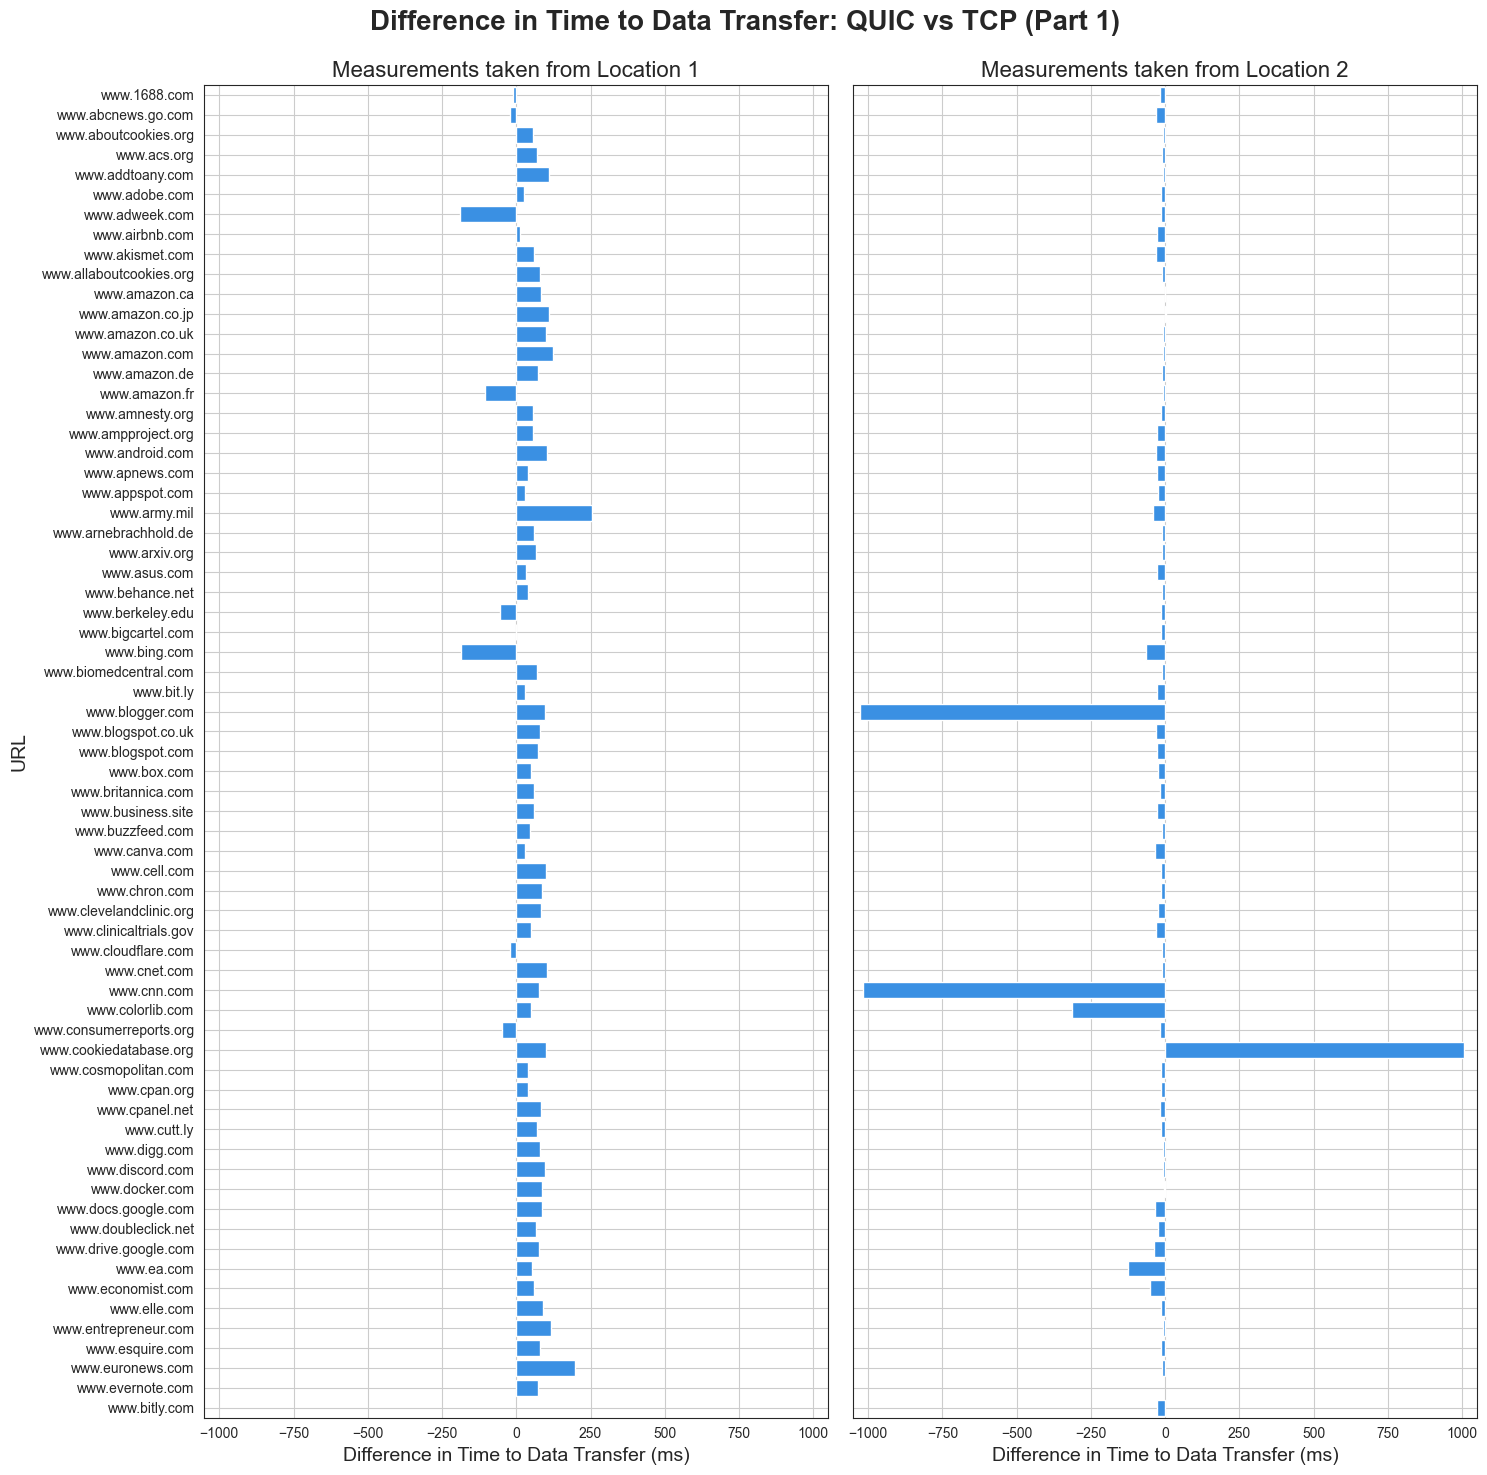

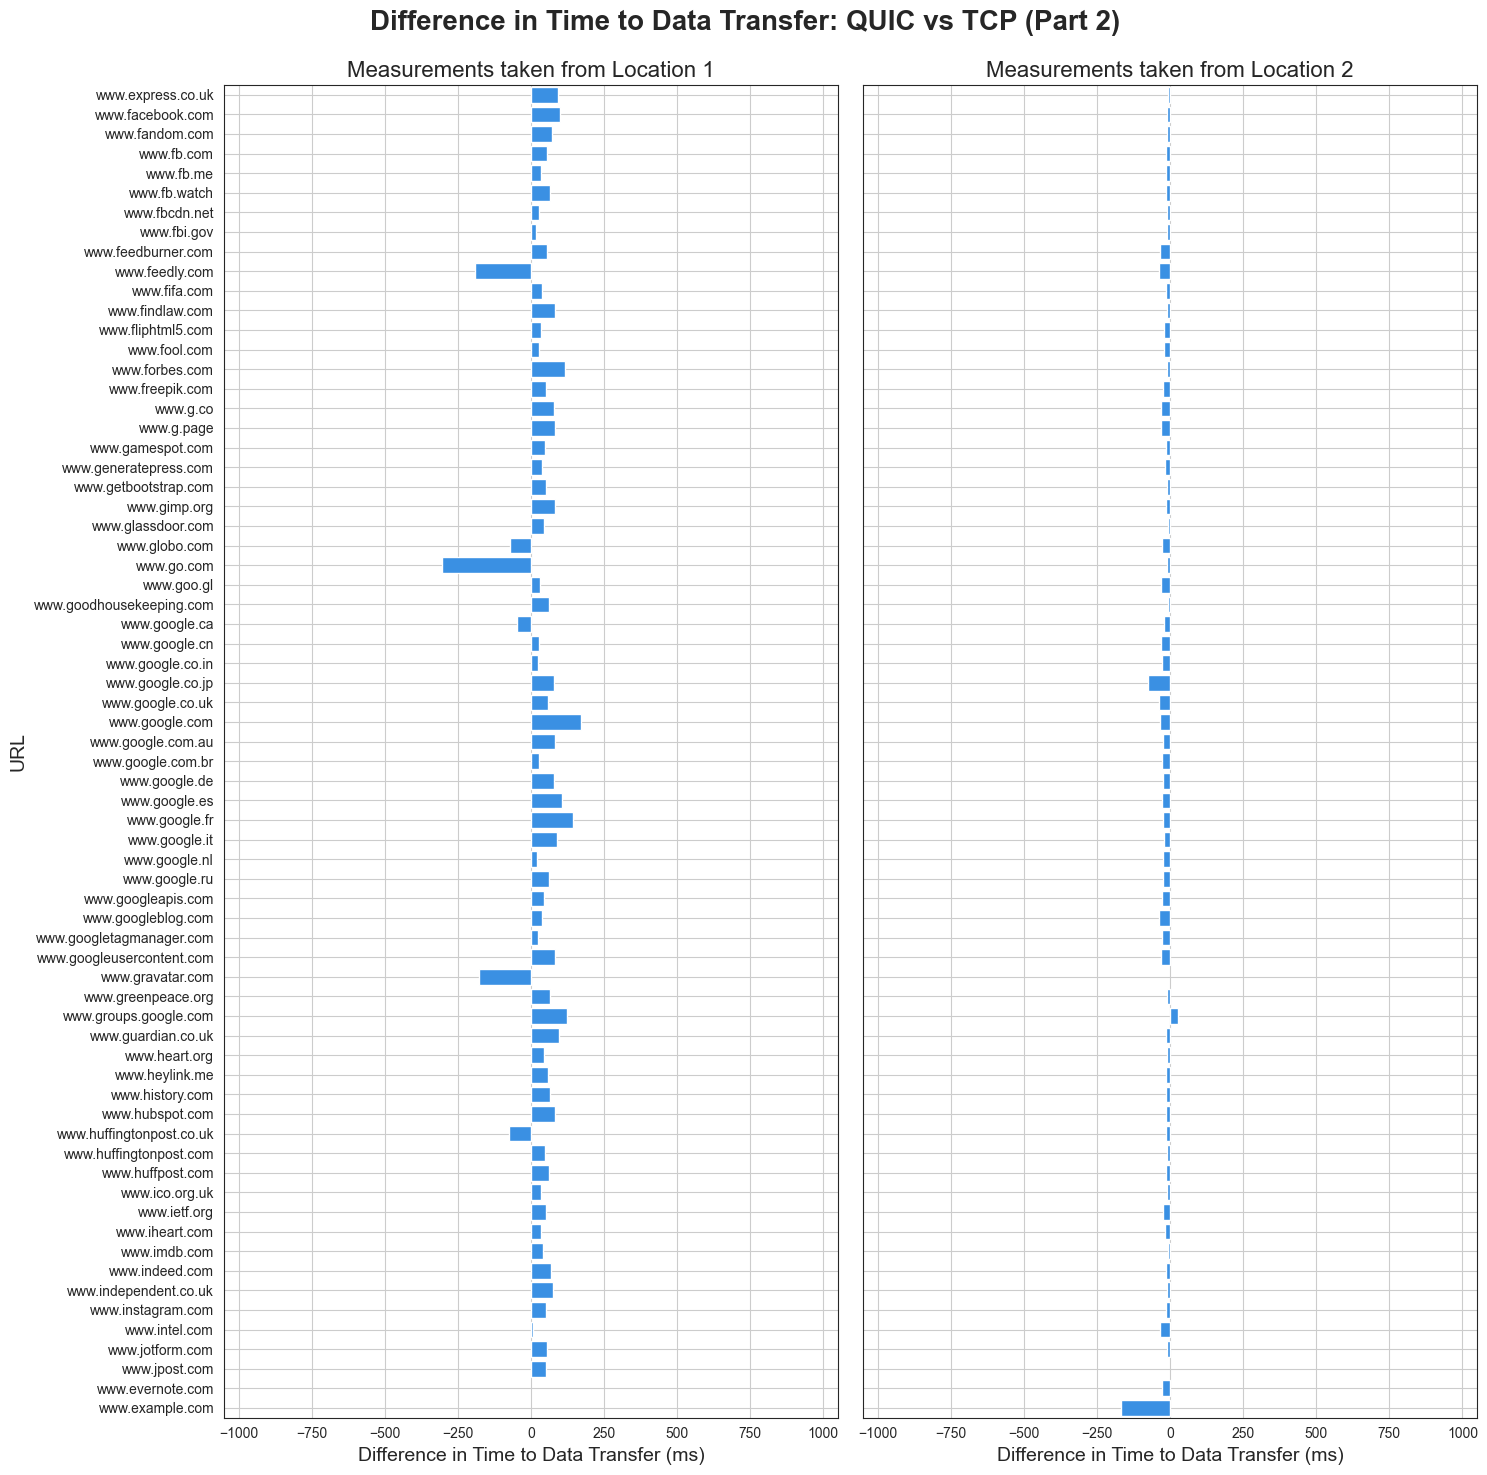

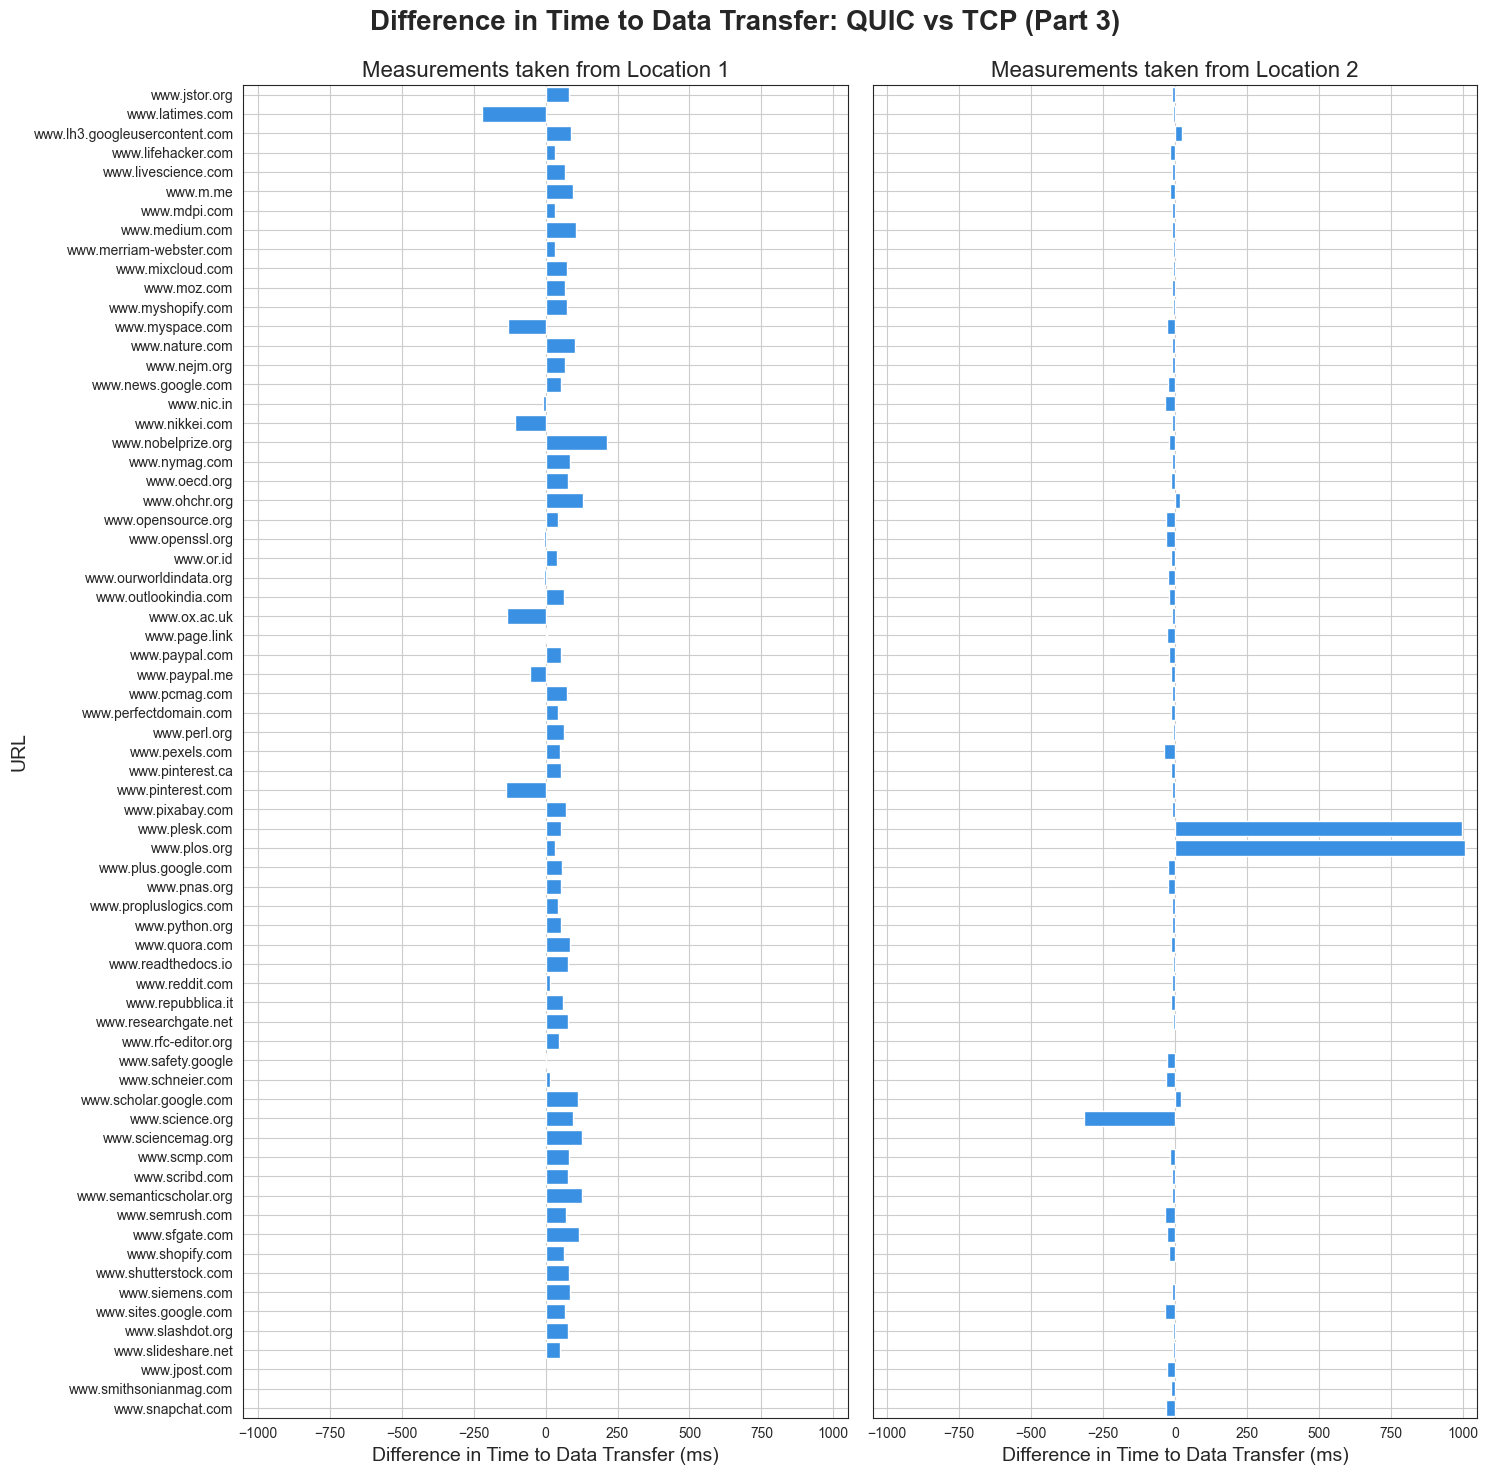

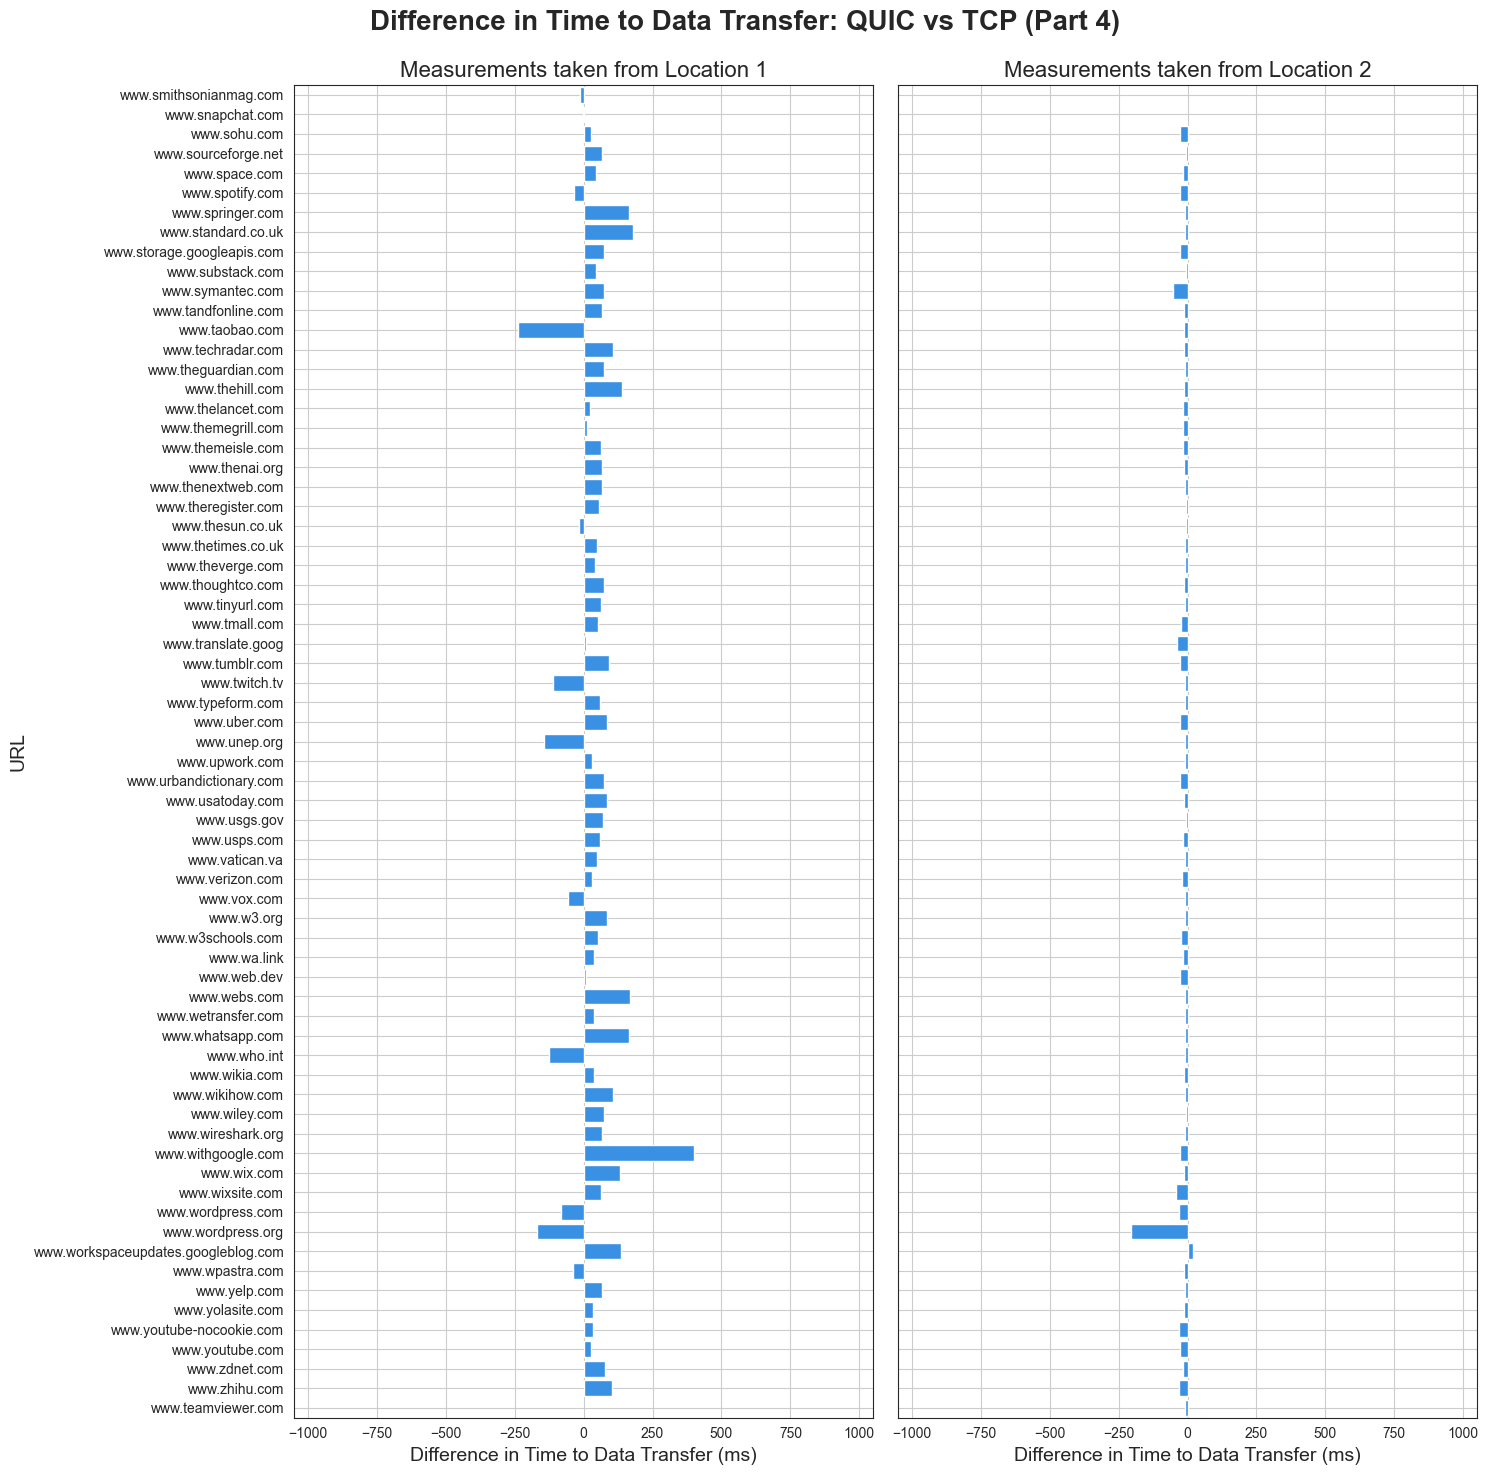

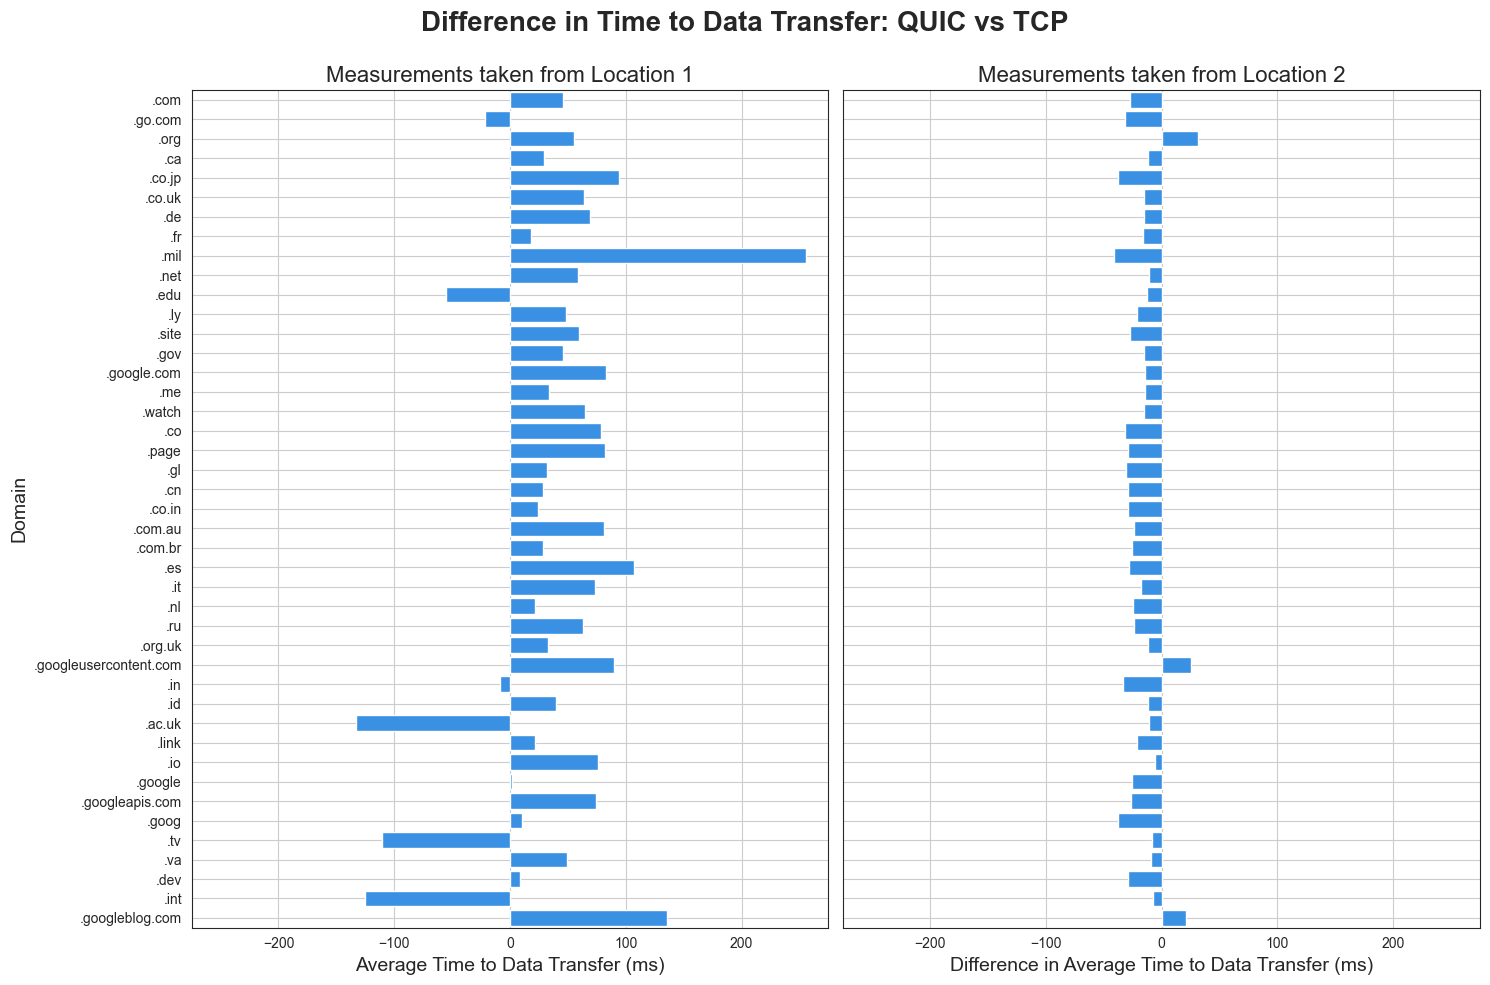

In [11]:
generateTimetoFirstByteURLDistribution(time_to_data_transfer, time_before_data_transfer_tcp)
generateTimetoFirstByteDomainDistribution(time_to_data_transfer, time_before_data_transfer_tcp)

### Generate *Connection Establishment* Visualisations

1 graph showing only duration of Connection Establishment Hanshake.

1 graph showing Time Taken before sending First Data Packet.

1 graph showing Average RTTS.


[39, 17] [205, 256]


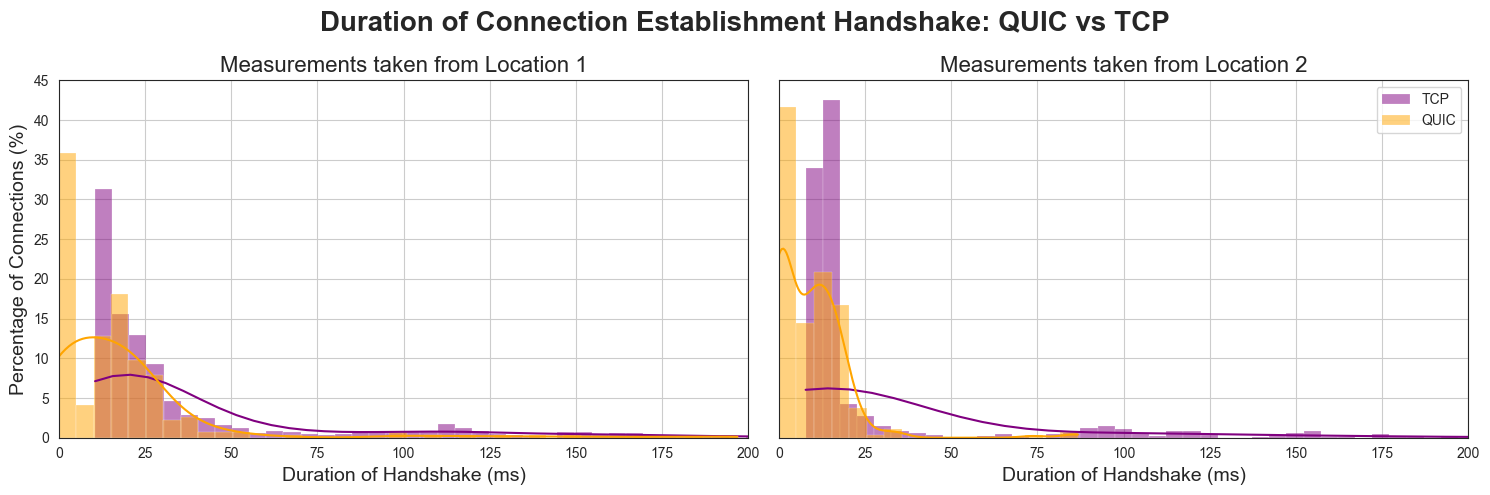

[95, 210] [218, 257]


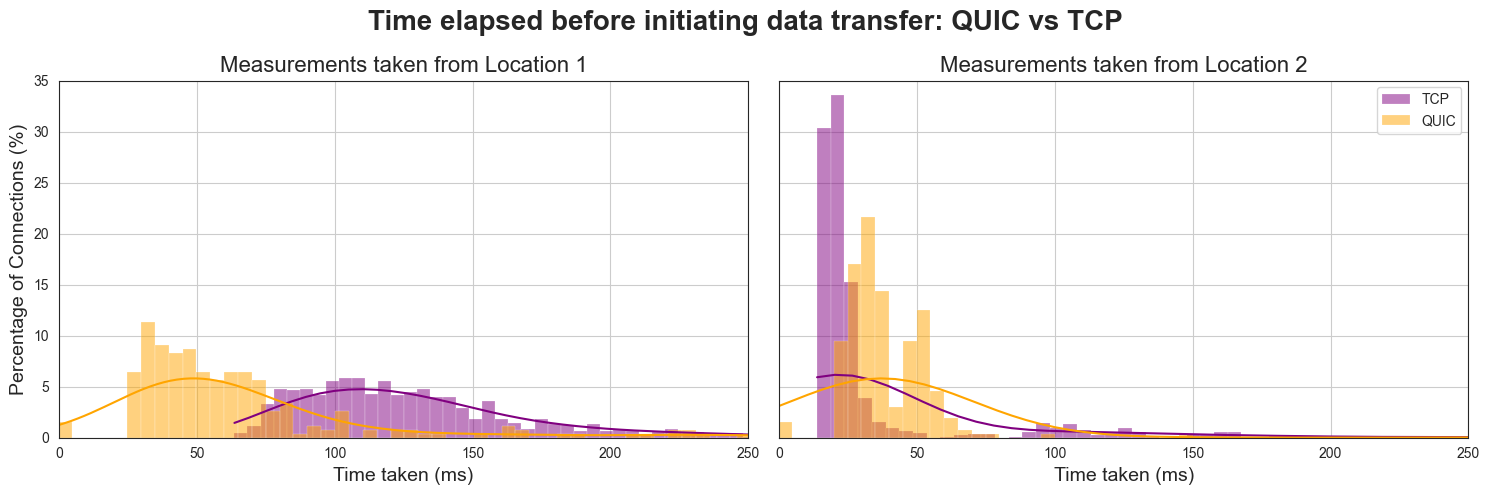

[51, 25] [152, 205]


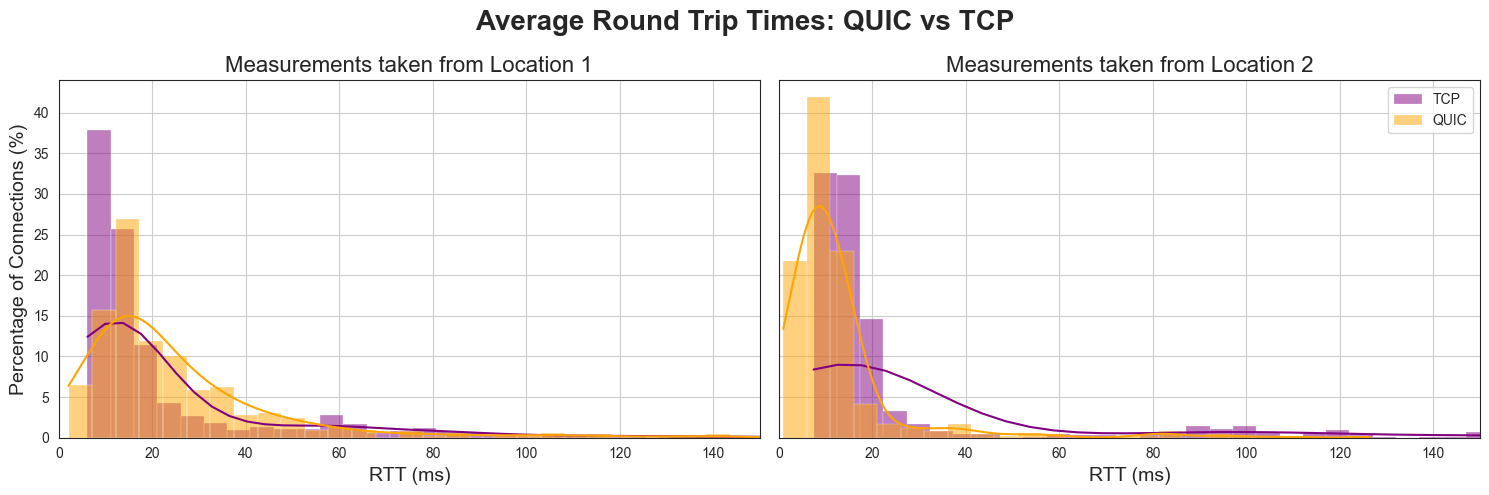

In [12]:
generateOverlappedHandshakeTimeDistribution(handshake_times, handshake_times_tcp)
generateOverlappedHandshakeTimeDistribution(time_to_data_transfer, time_before_data_transfer_tcp, type=2)
generateOverlappedHandshakeTimeDistribution(round_trip_times_quic, round_trip_times_tcp, type=3)

### Generate *Transport vs Security Handshake* Visualisations

1 graph showing QUIC combined handshake.

1 graph showing TCP 3-way Handshake and TLS Handshake.

[39, 17] [27, 17]


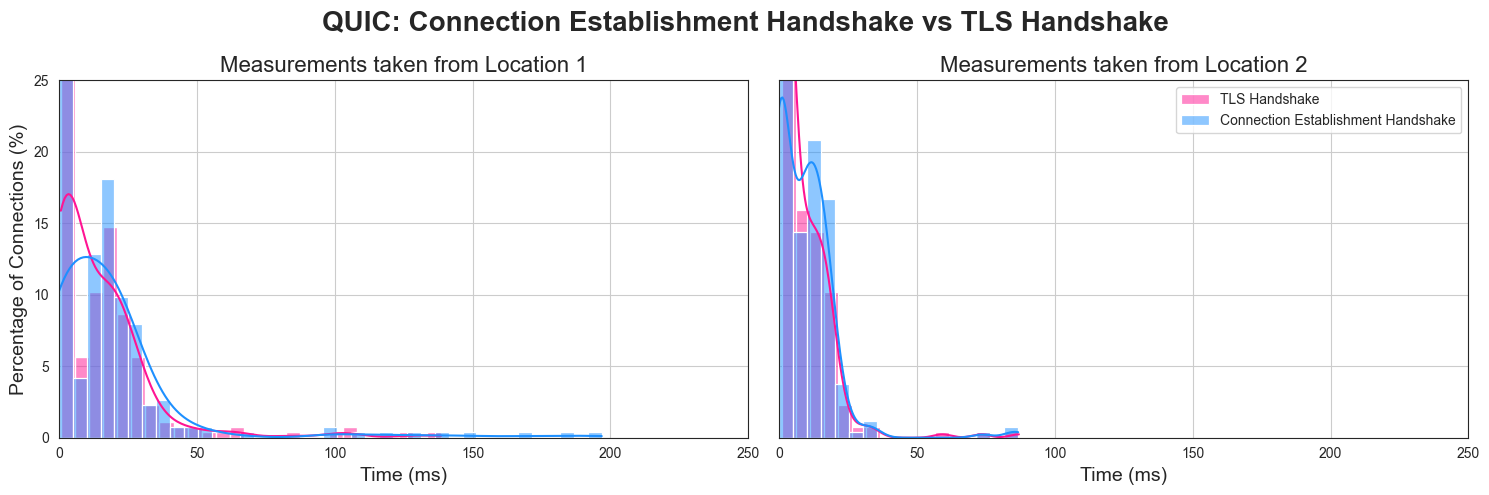

[205, 256] [2272, 568]


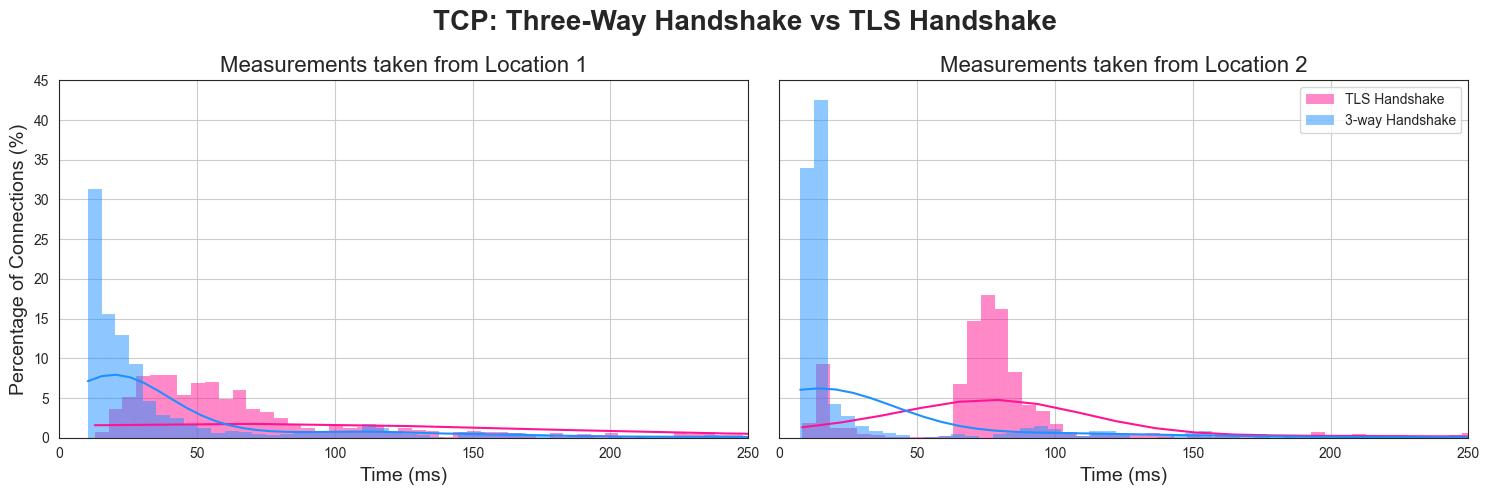

In [13]:
generateOverlappedHandshakeTimeDistribution(handshake_times, tls_handshake_times, type=4)
generateOverlappedHandshakeTimeDistribution(handshake_times_tcp, tls_handshake_times_tcp, type=5)

### Obtain Information for Tables

In [14]:
def findTLSVersionAndCiphers():
    tls_versions = {}
    tls_ciphers = {}

    for location in tls_packets:
        for website in tls_packets[location]:
            if len(tls_packets[location][website]) > 1:
                pkt = tls_packets[location][website][1]
                if pkt[TLS].msg:
                    
                    version = pkt[TLS].version if hasattr(pkt[TLS], 'version') else None
                    cipher = pkt[TLS].msg[0].cipher if hasattr(pkt[TLS].msg[0], 'cipher') else None

                    # TLS version
                    if version:
                        if version not in tls_versions:
                            if location == "home":
                                tls_versions[version] = {"home":1, "campus":0}
                            else:
                                tls_versions[version] = {"home":0, "campus":1}
                        else:
                            tls_versions[version][location] += 1
                    # TLS cipher
                    if cipher:
                        if cipher not in tls_ciphers:
                            if location == "home":
                                tls_ciphers[cipher] = {"home":1, "campus":0}
                            else:
                                tls_ciphers[cipher] = {"home":0, "campus":1}
                        else:
                            tls_ciphers[cipher][location] += 1

    return tls_versions, tls_ciphers


def findTLSHandshakeMessages():
    tls_connections = {"(1)client_hello":{"home":0, "campus":0}, 
                       "(2)server_hello":{"home":0, "campus":0}, 
                       "(3)server_key_exchange":{"home":0, "campus":0}, 
                       "(4)client_key_exchange":{"home":0, "campus":0}, 
                       "(5)change_cipher_spec":{"home":0, "campus":0}, 
                       "(6)finished":{"home":0, "campus":0}, 
                       "tls_alert":{"home":0, "campus":0}, 
                       "alert_before_key_exchange":{"home":0, "campus":0}, 
                       "alert_during_key_exchange":{"home":0, "campus":0}, 
                       }
    loc_count = {"home":0, "campus":0}

    for location in tls_packets:
        for website in tls_packets[location]:

            client_hello = False
            server_hello = False
            server_key_exchange = False
            client_key_exchange = False
            change_cipher_spec = False
            finished = False
            alert = False
            alert_before_key_exchange = False
            alert_during_key_exchange = False

            current_cipher = ''

            for pkt in tls_packets[location][website]:

                tls_record = pkt[TLS]

                if tls_record.msg:
                    cipher = pkt[TLS].msg[0].cipher if hasattr(pkt[TLS].msg[0], 'cipher') else None
                
                if cipher:
                    current_cipher = cipher

                if TLSClientHello in tls_record.msg[0]:
                    client_hello = True

                elif TLSServerHello in tls_record.msg[0]:
                    server_hello = True

                elif TLSServerKeyExchange in tls_record.msg[0]:
                    server_key_exchange = True

                elif TLSClientKeyExchange in tls_record.msg[0]:
                    client_key_exchange = True

                elif TLSChangeCipherSpec in tls_record.msg[0]:
                    change_cipher_spec = True

                elif TLSFinished in tls_record.msg[0]:
                    finished = True
                    
                elif TLSAlert in tls_record.msg[0]:
                    alert = True
                    #print(current_cipher)
                    tls_connections["tls_alert"][location] += 1
                    #pprint.pprint(tls_record.msg[0])
                    #print(tls_record.msg[0].descr)
                    #print(location)
                    if not client_key_exchange:
                        alert_during_key_exchange = True
                    if not server_key_exchange:
                        alert_before_key_exchange = True

            if client_hello and not server_hello:
                tls_connections["(1)client_hello"][location] += 1
            elif client_hello and server_hello and not server_key_exchange:
                tls_connections["(2)server_hello"][location] += 1
            elif client_hello and server_hello and server_key_exchange and not client_key_exchange:
                tls_connections["(3)server_key_exchange"][location] += 1
            elif client_hello and server_hello and server_key_exchange and client_key_exchange and not change_cipher_spec:
                tls_connections["(4)client_key_exchange"][location] += 1
            elif client_hello and server_hello and server_key_exchange and client_key_exchange and change_cipher_spec and not finished:
                tls_connections["(5)change_cipher_spec"][location] += 1
            elif client_hello and server_hello and server_key_exchange and client_key_exchange and change_cipher_spec and finished:
                tls_connections["(6)finished"][location] += 1

            if alert:
                if alert_before_key_exchange:
                    tls_connections["alert_before_key_exchange"][location] += 1
                if alert_during_key_exchange:
                    tls_connections["alert_during_key_exchange"][location] += 1
    return tls_connections

### Displaying Tables for TLS Information

In [15]:

def getTLSErrors(error_reasons):
    count_errors = {}
    for location in error_reasons:
        for k, v in error_reasons[location].items():
            if v != '':
                if v in count_errors:
                    count_errors[v][location] += 1
                else:
                    if location == "home":
                        count_errors[v] = {"home": 1, "campus": 0}
                    else:
                        count_errors[v] = {"home": 0, "campus": 1}
    
    data = []
    for error, counts in count_errors.items():
        data.append((error, counts["home"], counts["campus"]))

    columns = pd.MultiIndex.from_tuples([('Error', ''), ('Location', 'home'), ('Location', 'campus')])
    df = pd.DataFrame(data, columns=columns).fillna(0)
    display(df)   


def getTLSEstablishedInfo(tls_established):    
    tls_ciphers = {}
    for location in tls_established:
        for k, v in tls_established[location].items():
            for cipher in v:
                if cipher in tls_ciphers:
                    tls_ciphers[cipher][location] += 1
                else:
                    if location == "home":
                        tls_ciphers[cipher] = {"home": 1, "campus": 0}
                    else:
                        tls_ciphers[cipher] = {"home": 0, "campus": 1}

    data = []
    for cipher, counts in tls_ciphers.items():
        if cipher != "None":
            data.append((cipher, counts["home"], counts["campus"]))

    columns = pd.MultiIndex.from_tuples([('TLS Cipher', ''), ('Location', 'home'), ('Location', 'campus')])
    df = pd.DataFrame(data, columns=columns).fillna(0)
    display(df)

  
def displayDataframe(tls_info, title="TLS"):
    data = []
    for info, counts in tls_info.items():
        if info != "None":
            data.append((info, counts["home"], counts["campus"]))

    columns = pd.MultiIndex.from_tuples([(title, ''), ('Location', 'home'), ('Location', 'campus')])
    df = pd.DataFrame(data, columns=columns).fillna(0)
    display(df)

### Display Statistical Information in Tables

In [16]:
print("QUIC INFORMATION")
getTLSErrors(error_reasons)
getTLSEstablishedInfo(tls_established)


tls_versions, tls_ciphers = findTLSVersionAndCiphers()
tls_connections = findTLSHandshakeMessages()

print("\n\nTCP INFORMATION")
displayDataframe(tls_ciphers, "TLS Ciphers")
displayDataframe(tls_versions, "TLS Versions")
displayDataframe(tls_connections, "TLS Handshake Information")


QUIC INFORMATION


Error  \
                                                                         
0                                                              kthxbye   
1    200:TLS handshake failure (ENCRYPTION_INITIAL) 80: internal error   
2                                                     handshake failed   
3                                                 28:Reject connection   
4                                                         TLS alert 80   
5  28:TLS handshake failure (ENCRYPTION_INITIAL) 40: handshake failure   
6                                                 cannot decrypt token   

  Location         
      home campus  
0      257    256  
1      155    148  
2        2      3  
3        1      2  
4        1      2  
5        2      2  
6        0      2

TLS Cipher Location       
                        home campus
0  Some(AES256_GCM)       70     70
1  Some(AES128_GCM)      191    190



TCP INFORMATION


TLS Ciphers Location       
                  home campus
0       49199       55     56
1        4865      217    230
2        4866      492    484
3         159        1      1
4       49196        2      2
5       49195        9      9
6       52392       52     52
7       49200       42     39
8       52393        9      9
9        4867       10     10

TLS Versions Location       
                   home campus
0          771      906    909
1          769        0      1

TLS Handshake Information Location       
                                 home campus
0            (1)client_hello        0      0
1            (2)server_hello      905    907
2     (3)server_key_exchange        0      1
3     (4)client_key_exchange        0      0
4      (5)change_cipher_spec        1      2
5                (6)finished        0      0
6                  tls_alert       32     12
7  alert_before_key_exchange       23     12
8  alert_during_key_exchange        1      0

### Generate Overall Average RTT for QUIC and TCP Connections

In [17]:
def parseTCPRTTdata(rtt_data):
    overall_rtt_data = {'Avg Overall Client RTT': [], 
                        'Avg Overall Server RTT': [], 
                        'Avg Overall Total RTT': []}
    for location in rtt_data:
        for website in rtt_data[location]:
            #print(rtt_data[location])
            #print("client" , rtt_data[location][website]['Avg Client RTT'])
            if rtt_data[location][website]['Avg Client RTT']:
                overall_rtt_data['Avg Overall Client RTT'].append(float(rtt_data[location][website]['Avg Client RTT']))
            #print("server" , rtt_data[location][website]['Avg Server RTT'])
            if rtt_data[location][website]['Avg Server RTT']:
                overall_rtt_data['Avg Overall Server RTT'].append(float(rtt_data[location][website]['Avg Server RTT']))
            #print("total" , rtt_data[location][website]['Avg Total RTT'])
            if rtt_data[location][website]['Avg Total RTT']:
                overall_rtt_data['Avg Overall Total RTT'].append(float(rtt_data[location][website]['Avg Total RTT']))
    
    overall_rtt_data['Avg Overall Client RTT'] = np.mean(overall_rtt_data['Avg Overall Client RTT']) * 1000
    overall_rtt_data['Avg Overall Server RTT'] = np.mean(overall_rtt_data['Avg Overall Server RTT']) * 1000
    overall_rtt_data['Avg Overall Total RTT'] = np.mean(overall_rtt_data['Avg Overall Total RTT']) * 1000

    return overall_rtt_data

def parseRTTdata(rtt_data):
    overall_rtt_data = []
    for location in rtt_data:
        for website in rtt_data[location]:
            if rtt_data[location][website]:
                overall_rtt_data.append(float(rtt_data[location][website]))

    return np.mean(overall_rtt_data)



overall_rtt_tcp = parseRTTdata(round_trip_times_tcp)
overall_rtt_quic = parseRTTdata(round_trip_times_quic)
print("TCP Overall Average RTT: " + str(overall_rtt_tcp))
print("QUIC Overall Average RTT: " + str(overall_rtt_quic))

TCP Overall Average RTT: 29.532312603192075
QUIC Overall Average RTT: 19.498673421660556


# Investigate Support for QUIC & TCP

### Find Number of Successful vs Failed Connections for QUIC and TCP

In [18]:
def findNoOfEstablishedConnections(handshake_times):
    count_home = 0
    count_campus = 0
    trials_home = 0
    trials_campus = 0
    failed_trials_home = 0
    failed_trials_campus = 0
    for location in handshake_times:
        for url, value in handshake_times[location].items():
            if location == "home":
                trials_home += 1
                if value != None:
                    count_home += 1
                else:
                    failed_trials_home += 1
            elif location == "campus":
                trials_campus += 1
                if value != None:
                    count_campus += 1
                else:
                    failed_trials_campus += 1
    
    count_total = count_home + count_campus
    total_trials = trials_home + trials_campus
    total_failed_trials = failed_trials_home + failed_trials_campus

    return {"home connections": count_home, 
            "campus connections": count_campus, 
            "total connections": count_total,
            "home trials": trials_home,
            "campus trials": trials_campus,
            "total trials": total_trials,
            "failed trials home": failed_trials_home,
            "failed trials campus": failed_trials_campus,
            "total failed trials": total_failed_trials
            }

print("Total connections established with QUIC: ")
quic_connections = findNoOfEstablishedConnections(handshake_times)
pprint.pprint(quic_connections)
print("Total connections established with TCP: ")
tcp_connections = findNoOfEstablishedConnections(handshake_times_tcp)
pprint.pprint(tcp_connections)

Total connections established with QUIC: 
{'campus connections': 264,
 'campus trials': 920,
 'failed trials campus': 656,
 'failed trials home': 652,
 'home connections': 265,
 'home trials': 917,
 'total connections': 529,
 'total failed trials': 1308,
 'total trials': 1837}
Total connections established with TCP: 
{'campus connections': 910,
 'campus trials': 910,
 'failed trials campus': 0,
 'failed trials home': 0,
 'home connections': 907,
 'home trials': 907,
 'total connections': 1817,
 'total failed trials': 0,
 'total trials': 1817}


### Generate Sankey Diagram for Easier Visualisation of Data

In [19]:
import plotly.graph_objects as go


fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 15,
      line = dict(color = "black", width = 0.5),
      label = ["Total QUIC Connection Trials", "Location 1 QUIC Connection Trials", "Location 2 QUIC Connection Trials", "Established QUIC Connections", "Failed QUIC Connections", "Total TCP Connection Trials", "Location 1 TCP Connection Trials", "Location 2 TCP Connection Trials", "Established TCP Connections", "Failed TCP Connections"],
      color = ["mediumpurple", "cornflowerblue", "lightskyblue", 'lightseagreen', 'mediumvioletred', "mediumpurple", "cornflowerblue", "lightskyblue", 'lightseagreen'],
    ),
    link = dict(
      source = [0, 0, 1, 1, 2, 2, 5, 5, 6, 6, 7, 7], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = [1, 2, 3, 4, 3, 4, 6, 7, 8, 9, 8, 9],
      value = [quic_connections["home trials"], quic_connections["campus trials"], quic_connections["home connections"], quic_connections["failed trials home"], quic_connections["campus connections"],  quic_connections["failed trials campus"], tcp_connections["home trials"], tcp_connections["campus trials"], tcp_connections["home connections"], tcp_connections["failed trials home"], tcp_connections["campus connections"],  tcp_connections["failed trials campus"]],
  ))])

fig.update_layout(
    title_text="Established vs Failed Connections: QUIC & TCP",
    font_size=10
)


fig.show()